In [4]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import json
import requests
import pickle

## Splited Avg Exp Mat

In [5]:
fillist = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/10X-SC-FileList.txt"

In [6]:
flist = [l.strip() for l in open(fillist, 'rt').readlines()]

In [7]:
flist[:5]

['/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10XMulti/20230830/WMB-10XMulti-log2.h5ad',
 '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-CTXsp-log2.h5ad',
 '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-4-log2.h5ad',
 '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad',
 '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad']

In [6]:
adata = anndata.read_h5ad(test_fil,backed='r')
print(adata)

AnnData object with n_obs × n_vars = 285167 × 32285 backed at '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-STR-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


In [7]:
version = '20230830'
download_base = '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [8]:
version = '20230830'
download_base = '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root'
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-10X']['directories']['metadata']['relative_path'], 
                              'views')
cell_extended = pd.read_csv(os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv'))

/tmp/ipykernel_3271348/145630417.py:6: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_extended = pd.read_csv(os.path.join( view_directory, 'cell_metadata_with_cluster_annotation.csv'))


In [15]:
#cell_extended.to_csv("dat/cell_metadata_with_cluster_annotation.csv")
cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")

/tmp/ipykernel_42151/3143937820.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")


In [11]:
# class
# subclass
# supertype
# cluster

In [12]:
# Aggregate Cells to each Cell Type

In [13]:
# Class
label="class"
groupnames = cell_extended[label].unique()
group2barcode = {}
for groupname in groupnames:
    tmpdf = cell_extended[cell_extended[label]==groupname]
    group2barcode[groupname] = tmpdf["cell_barcode"].values

In [14]:
adata.var.index.values

array(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102331',
       ..., 'ENSMUSG00000094855', 'ENSMUSG00000095019',
       'ENSMUSG00000095041'], dtype=object)

In [16]:
dat = []
group_names = []
for group, cells in group2barcode.items():
    print(group, len(cells))
    group_names.append(group)
    cells = group2barcode[group]
    submat = adata[adata.obs["cell_barcode"].isin(cells)]
    test = submat.to_df()
    mean = test.mean(axis=0)
    dat.append(mean.values)

01 IT-ET Glut
11 CNU-HYa GABA
05 OB-IMN GABA
09 CNU-LGE GABA
13 CNU-HYa Glut
10 LSX GABA
12 HY GABA
20 MB GABA
08 CNU-MGE GABA
07 CTX-MGE GABA
06 CTX-CGE GABA
02 NP-CT-L6b Glut
04 DG-IMN Glut
30 Astro-Epen
15 HY Gnrh1 Glut
14 HY Glut
19 MB Glut
17 MH-LH Glut
27 MY GABA
24 MY Glut
23 P Glut
26 P GABA
16 HY MM Glut
21 MB Dopa
03 OB-CR Glut
22 MB-HB Sero
28 CB GABA
29 CB Glut
18 TH Glut
25 Pineal Glut
31 OPC-Oligo
32 OEC
33 Vascular
34 Immune


In [24]:
dat = np.array(dat).transpose()
dat.shape

(32285, 34)

In [25]:
df = pd.DataFrame(data=dat, index=adata.var.index.values, columns=list(group2barcode.keys()))

In [9]:
def SaveDict(Dict, fname):
    with open(fname, 'wb') as hand:
        pickle.dump(Dict, hand)
    return

def LoadDict(fname):
    with open(fname, 'rb') as hand:
        b = pickle.load(hand)
        return b

def AggregateExpMat2Cluster(adata, label, name):
    # Class
    groupnames = cell_extended[label].unique()
    print(len(groupnames),"uniq groups")
    group2barcode = {}
    for groupname in groupnames:
        tmpdf = cell_extended[cell_extended[label]==groupname]
        group2barcode[groupname] = tmpdf["cell_barcode"].values
        
    dat = []
    group_names = []
    CellType2NCell = {}
    for group, cells in group2barcode.items():
        print(group, len(cells))
        cells = group2barcode[group]
        submat = adata[adata.obs["cell_barcode"].isin(cells)]
        if submat.shape[0] == 0: # No cell barcode in this cell type
            continue   
        CellType2NCell[group] = submat.shape[0]
        test = submat.to_df()
        mean = test.mean(axis=0)
        group_names.append(group)
        dat.append(mean.values)
    dat = np.array(dat).transpose()
    df = pd.DataFrame(data=dat, index=adata.var.index.values, columns=group_names)
    df.to_csv("dat/AggregatedExpMat/ExpMat.{}.{}.csv".format(name, label))
    SaveDict(CellType2NCell, "dat/AggregatedExpMat/NumCells.{}.{}.csv".format(name, label))
    return

In [10]:
%%time
AggregateExpMat2Cluster(adata, "subclass", "WMB-10Xv3-STR")

NameError: name 'adata' is not defined

In [14]:
label = "subclass"
groupnames = cell_extended[label].unique()
print(len(groupnames),"uniq groups")
group2barcode = {}
for groupname in groupnames:
    tmpdf = cell_extended[cell_extended[label]==groupname]
    group2barcode[groupname] = tmpdf["cell_barcode"].values

NameError: name 'cell_extended' is not defined

In [42]:
group = "282 POR Spp1 Gly-Gaba"
group = "244 MV-SPIV Slc6a2 Glut"
cells = group2barcode[group]
submat = adata[adata.obs["cell_barcode"].isin(cells)]

In [43]:
submat

View of AnnData object with n_obs × n_vars = 37 × 32285 backed at '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-STR-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'

In [44]:
submat.shape

(37, 32285)

## Combine splited Exp Avg mat


In [56]:
Split_Exp_Dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/AggregatedExpMat/"

In [26]:
testfil = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-2-log2.h5ad"

In [12]:
adata = anndata.read_h5ad(testfil, backed='r')

In [24]:
test_cell_meta = pd.read_csv("dat/Cell_Meta_Splited/WMB-10Xv2-Isocortex-2.meta.csv", index_col=0)

In [28]:
adata = anndata.read_h5ad(testfil, backed='r')
print(adata)

AnnData object with n_obs × n_vars = 250040 × 32285 backed at '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-2-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'


In [30]:
test_cell_meta.head(3)

,Unnamed: 0,cell_label,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,...,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
3024035,3024035,AGCAGCCTCGCAGGCT-098_F01,AGCAGCCTCGCAGGCT,098_F01,L8TX_190312_01_D01,WMB-10Xv2-Isocortex-2,cell,NaN,10Xv2,SSp,...,030 L6 CT CTX Glut,0115 L6 CT CTX Glut_2,0443 L6 CT CTX Glut_2,#2B93DF,#61e2a4,#34661F,#3DCC96,#458299,3,#5CCCCC
3024036,3024036,AGCCTAAAGACAAGCC-098_F01,AGCCTAAAGACAAGCC,098_F01,L8TX_190312_01_D01,WMB-10Xv2-Isocortex-2,cell,NaN,10Xv2,SSp,...,030 L6 CT CTX Glut,0115 L6 CT CTX Glut_2,0442 L6 CT CTX Glut_2,#2B93DF,#61e2a4,#34661F,#3DCC96,#CC8700,3,#5CCCCC
3024037,3024037,AGCGTATCACATTTCT-098_F01,AGCGTATCACATTTCT,098_F01,L8TX_190312_01_D01,WMB-10Xv2-Isocortex-2,cell,NaN,10Xv2,SSp,...,030 L6 CT CTX Glut,0114 L6 CT CTX Glut_1,0436 L6 CT CTX Glut_1,#2B93DF,#61e2a4,#34661F,#CC3D77,#349900,3,#5CCCCC


In [69]:
test_celltype = "046 Vip Gaba"
test_celltype = "053 Sst Gaba"
test_celltype = "002 IT EP-CLA Glut"
test_celltype = "005 L5 IT CTX Glut"
cells = test_cell_meta[test_cell_meta["subclass"]==test_celltype]["cell_barcode"].values

In [70]:
submat = adata[adata.obs["cell_barcode"].isin(cells)]

In [71]:
submat

View of AnnData object with n_obs × n_vars = 12209 × 32285 backed at '/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-2-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'

In [72]:
test = submat.to_df()

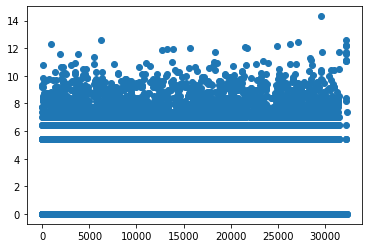

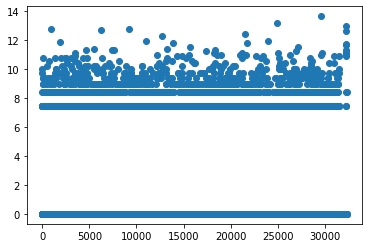

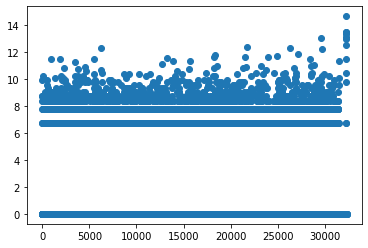

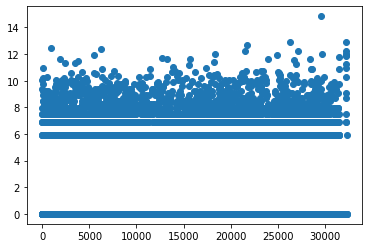

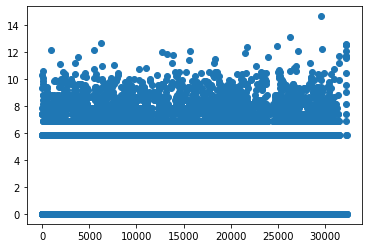

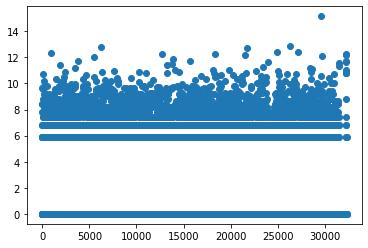

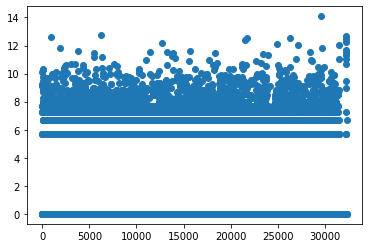

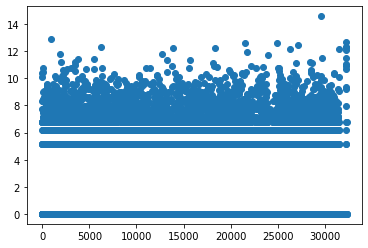

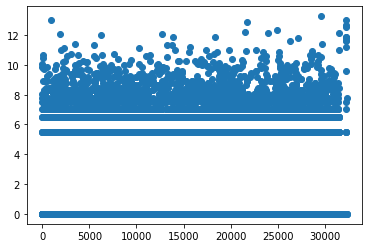

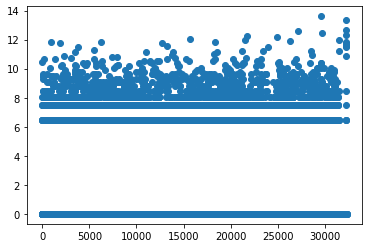

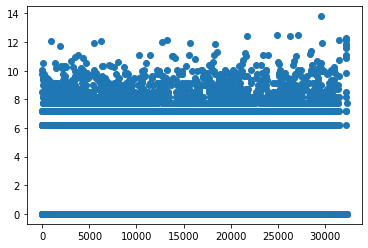

In [73]:
count = 0
for i, row in test.iterrows():
    plt.scatter(np.arange(len(row.values)), row.values)
    plt.show()
    count += 1
    if count >10:
        break

In [76]:
testfil = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-Isocortex-2-log2.h5ad"

In [77]:
adata = anndata.read_h5ad(testfil, backed='r')

In [78]:
test_cell_meta = pd.read_csv("dat/Cell_Meta_Splited/WMB-10Xv3-Isocortex-2.meta.csv", index_col=0)

/tmp/ipykernel_42151/1967185434.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  test_cell_meta = pd.read_csv("dat/Cell_Meta_Splited/WMB-10Xv3-Isocortex-2.meta.csv", index_col=0)


In [79]:
test_celltype = "046 Vip Gaba"
test_celltype = "053 Sst Gaba"
test_celltype = "002 IT EP-CLA Glut"
test_celltype = "005 L5 IT CTX Glut"
cells = test_cell_meta[test_cell_meta["subclass"]==test_celltype]["cell_barcode"].values

In [80]:
submat = adata[adata.obs["cell_barcode"].isin(cells)]
test = submat.to_df()

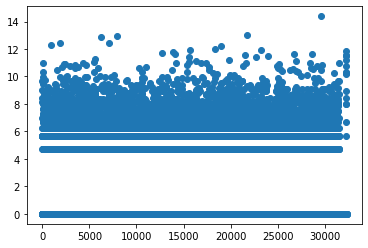

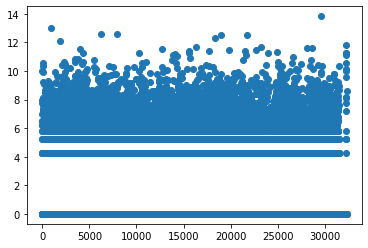

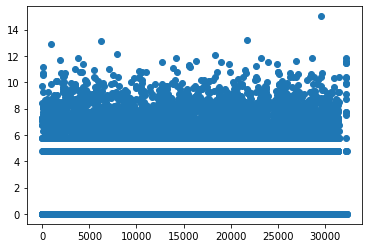

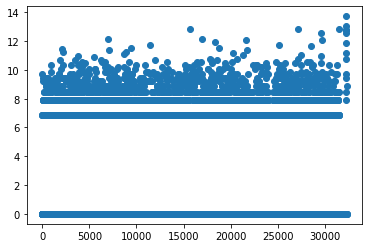

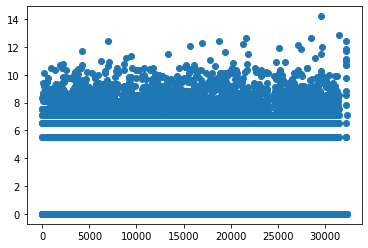

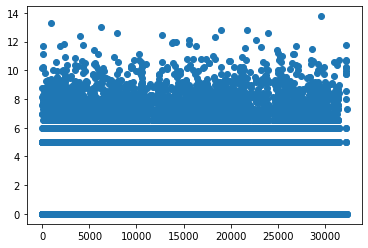

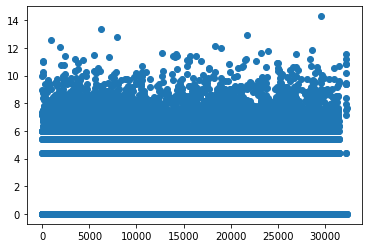

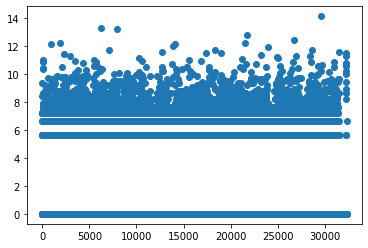

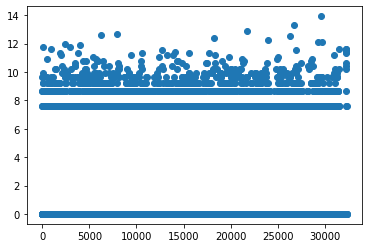

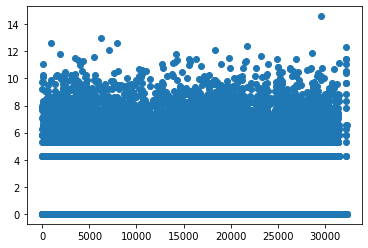

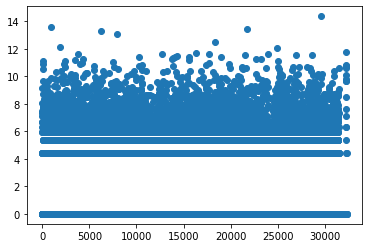

In [81]:
count = 0
for i, row in test.iterrows():
    plt.scatter(np.arange(len(row.values)), row.values)
    plt.show()
    count += 1
    if count >10:
        break